In [1]:
import pathlib, sys

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [2]:
import math
import numpy as np
from dataclasses import replace
import qutip
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
from tools.jupyter import print_model_info
from tools.qutip import TqdmProgressBar

In [4]:
n_bosons = 3
phase = 0  # np.pi / 4
# model = BEC_Qubits.init_alexey2003(n_bosons=n_bosons, phase=phase)
model = bec.BEC_Qubits.init_default(
    n_bosons=n_bosons,
    phase=phase,
    excitation_level=True,
)
print_model_info(model)

BEC_Qubits(n_bosons=3, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0, excitation_level=True, communication_line=False)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Активируем уровни возбудженного состояния и линии связи

In [5]:
ecmodel = replace(model, excitation_level=True, communication_line=True)

Начальное состояние системы: суперпозиция между атомами a и b

In [6]:
init_state = (
    bec.coherent_state_constructor(ecmodel, n=2, k=0)
    * bec.coherent_state_constructor(ecmodel, n=2, k=1)
    * bec.vacuum_state(ecmodel, n=2)
)

## Эволюция под действием "низкоуровневого" гамильтониана

Гамильтониан $H_\mathrm{int}$ и $H_\mathrm{pump}$ из Alexey2013

In [7]:
tspan_alexey, dt = np.linspace(0, 2 /  model.Omega / 5, 401, retstep=True)

In [8]:
h_alexey = bec.h_int(ecmodel, true_hc=True) + bec.hamiltonian_laser_field(ecmodel)

/Users/kephircheek/Projects/RSF-Entanglement_Generation_between_BEC/research-emqwuqoc/libs/bec.py:86: UserWarning: Means \delta_l = \delta_c = \delta
  warnings.warn("Means \delta_l = \delta_c = \delta")


In [9]:
evolution_h_alexey = qutip.mesolve(
    h_alexey,
    init_state,
    tspan_alexey,
    progress_bar=TqdmProgressBar(),
    options=qutip.Options(nsteps=1e4),
)

/Users/kephircheek/venvs/science/emqwuqoc-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 401/401 [01:06<00:00,  5.99it/s]


Гамильтониан из Rosseau2014

In [10]:
tspan_rosseau, dt = np.linspace(0, 2 /  model.Omega / 20, 401, retstep=True)

In [11]:
h_rosseau = bec.hamiltonian_coupling(ecmodel) + bec.hamiltonian_laser_field(ecmodel)

/Users/kephircheek/Projects/RSF-Entanglement_Generation_between_BEC/research-emqwuqoc/libs/bec.py:86: UserWarning: Means \delta_l = \delta_c = \delta
  warnings.warn("Means \delta_l = \delta_c = \delta")


In [12]:
evolution_h_rosseau = qutip.mesolve(
    h_rosseau,
    init_state,
    tspan_rosseau,
    progress_bar=TqdmProgressBar(),
)

100%|██████████| 401/401 [00:04<00:00, 81.45it/s]


Эффективный гамильтониан из Rosseau2014

In [13]:
tspan_eff, dt = np.linspace(0, 2 /  model.Omega, 201, retstep=True)

In [14]:
h_eff = bec.hamiltonian_eff(model, n=2)

In [15]:
init_state_ = (
    bec.coherent_state_constructor(model, n=2, k=0)
    * bec.coherent_state_constructor(model, n=2, k=1)
    * bec.vacuum_state(model, n=2)
)
evolution_h_eff = qutip.mesolve(
    h_eff,
    init_state_,
    tspan_eff,
    progress_bar=TqdmProgressBar(),
)

100%|██████████| 201/201 [00:01<00:00, 186.25it/s]


### Зависимость энтропии от времени

In [16]:
entropy_h_rosseau_1 = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1])) for s in tqdm(evolution_h_rosseau.states)
]
entropy_h_rosseau_2 = [
    qutip.entropy_vn(qutip.ptrace(s, [4, 5])) for s in tqdm(evolution_h_rosseau.states)
]

100%|██████████| 401/401 [00:00<00:00, 2191.57it/s]


In [17]:
entropy_h_alexey_1 = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1])) for s in tqdm(evolution_h_alexey.states)
]
entropy_h_alexey_2 = [
    qutip.entropy_vn(qutip.ptrace(s, [4, 5])) for s in tqdm(evolution_h_alexey.states)
]

100%|██████████| 401/401 [00:00<00:00, 1870.08it/s]


In [18]:
entropy_h_eff_1 = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1])) for s in tqdm(evolution_h_eff.states)
]
entropy_h_eff_2 = [
    qutip.entropy_vn(qutip.ptrace(s, [3, 4])) for s in tqdm(evolution_h_eff.states)
]

100%|██████████| 201/201 [00:00<00:00, 2159.62it/s]


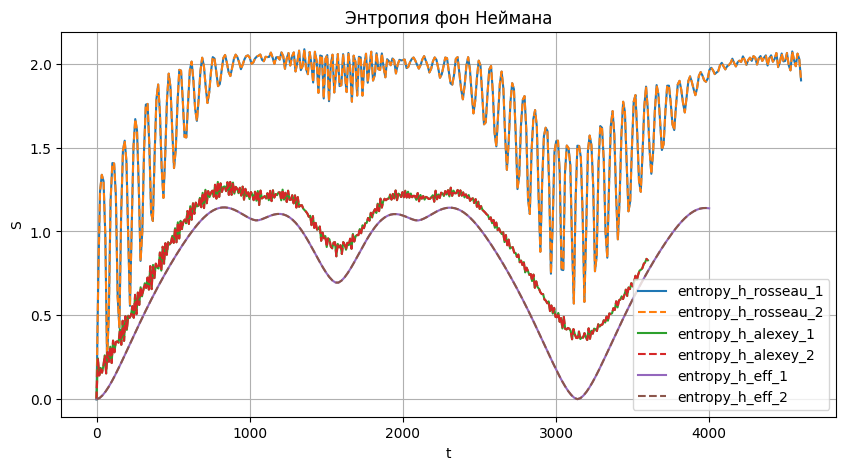

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan_rosseau * 23, np.array(entropy_h_rosseau_1), "-", label="entropy_h_rosseau_1")
ax.plot(tspan_rosseau * 23, entropy_h_rosseau_2, "--", label="entropy_h_rosseau_2")

ax.plot(tspan_alexey * 4.5, entropy_h_alexey_1, "-", label="entropy_h_alexey_1")
ax.plot(tspan_alexey * 4.5, entropy_h_alexey_2, "--", label="entropy_h_alexey_2")

ax.plot(tspan_eff, entropy_h_eff_1, "-", label="entropy_h_eff_1")
ax.plot(tspan_eff, entropy_h_eff_2, "--", label="entropy_h_eff_2")

ax.set_ylabel("S")
ax.set_xlabel("t")
ax.set_title("Энтропия фон Неймана")
ax.grid()
ax.legend()

plt.savefig(f"../entropy_vn-low-level-b{model.n_bosons}.pdf")

### Негативити

In [15]:
evolution_states_b1_c_b2 = [
    qutip.ptrace(s, [0, 1, 4, 5]) for s in tqdm(evolution.states)
]

100%|██████████| 3501/3501 [00:03<00:00, 878.21it/s]


In [16]:
evolution_states_b1_c_b2_partial_transposed = [
    qutip.partial_transpose(s, [0, 1, 0, 1]) for s in evolution_states_b1_c_b2
]

In [17]:
negativity = [
    np.log2(np.sum(np.abs(s.eigenenergies())))
    for s in tqdm(evolution_states_b1_c_b2_partial_transposed)
]

100%|██████████| 3501/3501 [02:39<00:00, 21.89it/s]


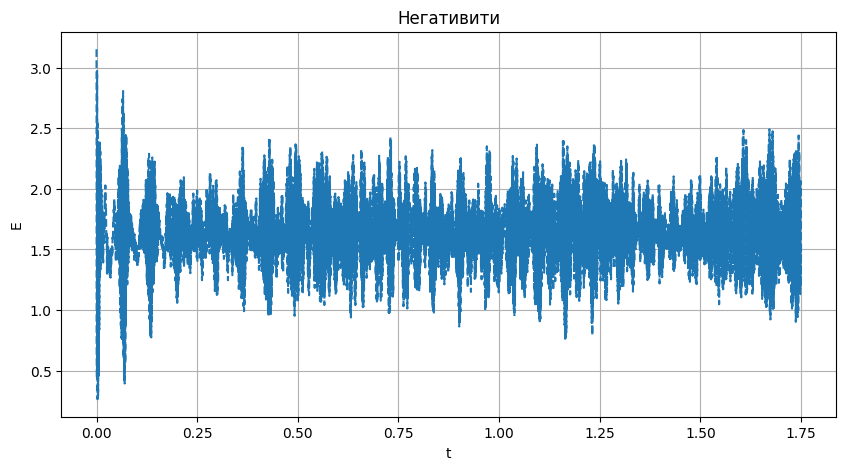

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan * ecmodel.Omega, negativity, "--", label="mesolve")
ax.set_ylabel("E")
ax.set_xlabel("t")
ax.set_title("Негативити")
ax.grid()